**Про сабмит:**

- строчный формат



*Baselines:*

- top10 popular

Берём по 1 последнему () item из датасета: \
**Таргет 1, так как взяли только случаи, когда юзеры взаимедействовали**
1. user_id --> idem_id(last)| gender&age(user_features)|genre_i (item_features) --> target (1)
2. Генерация негативных sample -- 9(neg):1(pos)

Про генерацию негативных samples: random(all_items - user_item):
- all_items - все items (пользователь взаимодействует только 1 раз с item)
- user_item - item, с котоорыми взаимодействовали пользователи

*Не особо сработает -->  нужно генерить фичи из того, что у нас есть*

200-300 фичей --> отбор по бустингу --> зоопарт моделей (запуск пропусков KNN (fniss), ALS (implicit), TopPoP,last) --> transformers on sequence (Bert4Rec,SasRec) --> итог

На разных моделей вылавливаем разные работы true-pos на своём сегменте --> ансамблирование по полученным моделям

In [82]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_format = 'retina'

In [4]:
df_events = pd.read_csv('events.csv')
df_item_feat = pd.read_csv('item_features.csv')
df_user_feat = pd.read_csv('user_features.csv')
df_sub_sample = pd.read_csv('submission_sample.csv')

df_events.head()

,user_id,item_id,rating,timestamp
0,0,1505,4,0
1,0,3669,3,1
2,0,584,4,2
3,0,3390,3,3
4,0,2885,4,4


**Какие данные есть?**

- пользователи: пол, возраст (есть возраст 1))) - df_user_feat
- фильмы - жанр - df_item_feat
- оценка фильма пользователем - df_events (user_id - item_id - rating - timestamp (в виде числа))

На выходе должны получить рекоммендацию для каждого юзера

In [6]:
df_sub_sample.head()
df_item_feat.head()
# df_user_feat.head()
df_events.head()

,user_id,item_id,rating,timestamp
0,0,1505,4,0
1,0,3669,3,1
2,0,584,4,2
3,0,3390,3,3
4,0,2885,4,4


#### Данные по пользователю

<Axes: title={'center': 'Распределение пользователей по полу'}>

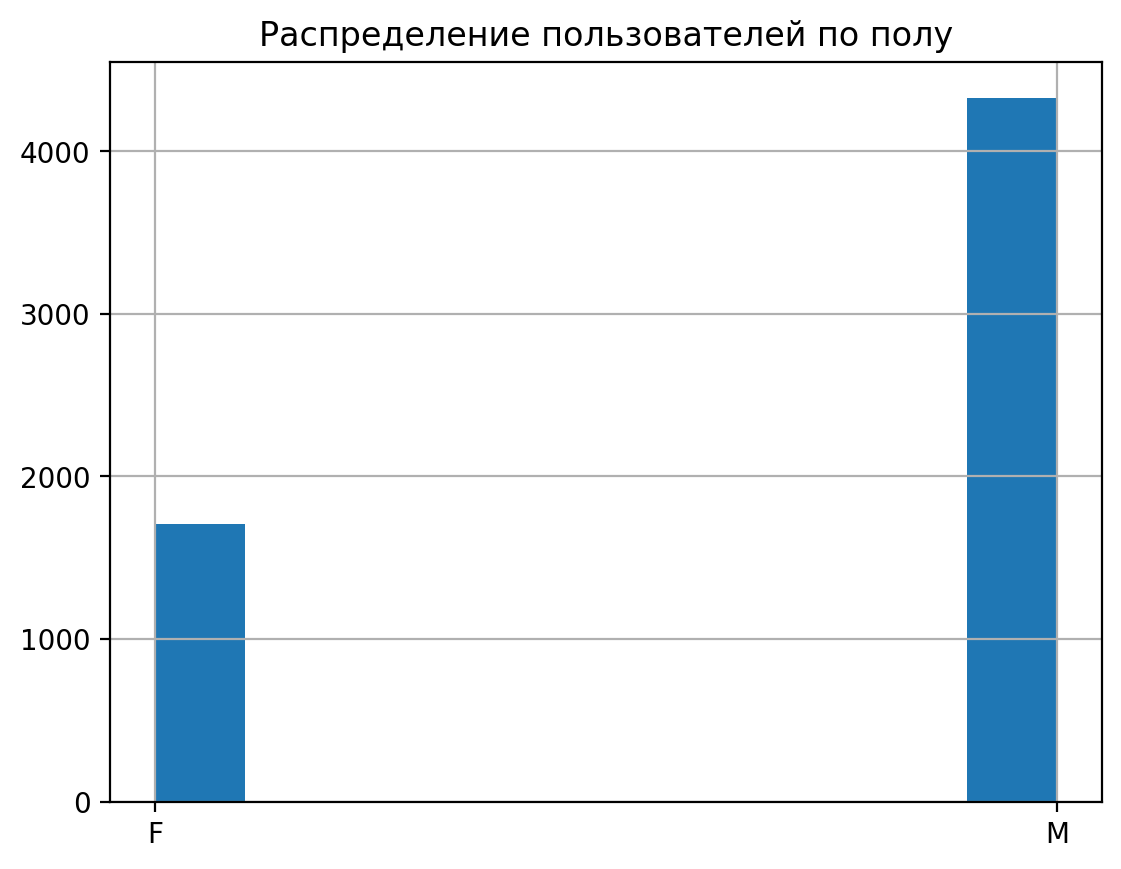

In [8]:
plt.title('Распределение пользователей по полу')
df_user_feat.gender.hist()

<Axes: title={'center': 'Распределение пользователей по возрасту'}>

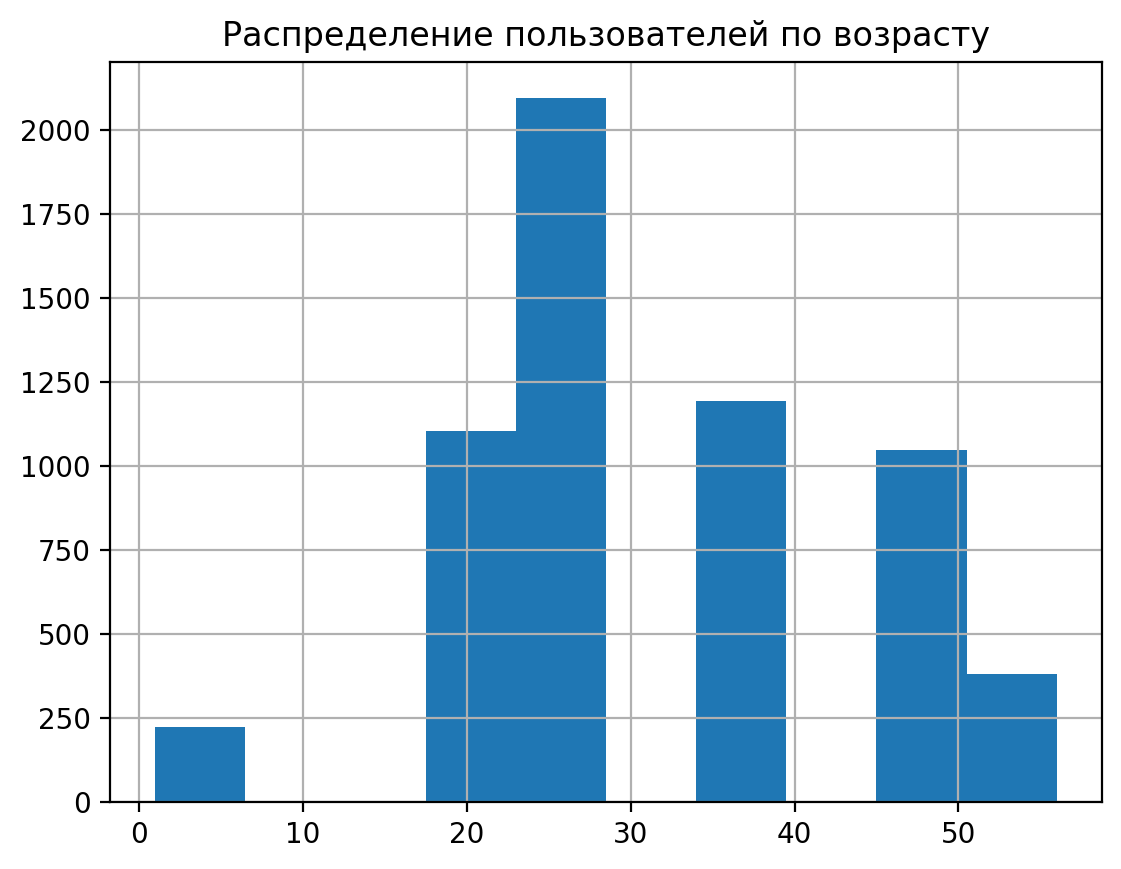

In [10]:
plt.title('Распределение пользователей по возрасту')
df_user_feat.age.hist()

**Есть те, у кого стоят 1 вместо возраста --> возраст неизвестен??**

In [13]:
df_user_feat[df_user_feat.age < 18]

,user_id,gender,age
0,4855,F,1
18,568,M,1
50,5595,F,1
74,4225,F,1
85,1308,F,1
...,...,...,...
5843,978,F,1
5952,2703,M,1
5972,3088,M,1
5988,1533,F,1


#### Данные по фильму

- Всего 3706 фильмов
- 18 жанров


Какие признаки можно использовать:
- период существования фильма
- 

In [17]:
df_item_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3706 entries, 0 to 3705
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   item_id   3706 non-null   int64
 1   genre_0   3706 non-null   int64
 2   genre_1   3706 non-null   int64
 3   genre_2   3706 non-null   int64
 4   genre_3   3706 non-null   int64
 5   genre_4   3706 non-null   int64
 6   genre_5   3706 non-null   int64
 7   genre_6   3706 non-null   int64
 8   genre_7   3706 non-null   int64
 9   genre_8   3706 non-null   int64
 10  genre_9   3706 non-null   int64
 11  genre_10  3706 non-null   int64
 12  genre_11  3706 non-null   int64
 13  genre_12  3706 non-null   int64
 14  genre_13  3706 non-null   int64
 15  genre_14  3706 non-null   int64
 16  genre_15  3706 non-null   int64
 17  genre_16  3706 non-null   int64
 18  genre_17  3706 non-null   int64
dtypes: int64(19)
memory usage: 550.2 KB


In [19]:
# Выбираем колонки, соответствующие маске
genre_columns = [col for col in df_item_feat.columns if col.startswith('genre_')]

# Подсчет количества жанров
df_item_feat['gen_cnt'] = df_item_feat[genre_columns].sum(axis=1)
df_item_feat

,item_id,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,gen_cnt
0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,5
1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,3,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,2
4,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3701,3701,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2
3702,3702,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3703,3703,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3704,3704,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


<Axes: title={'center': 'Кол-во жанров на фильм'}>

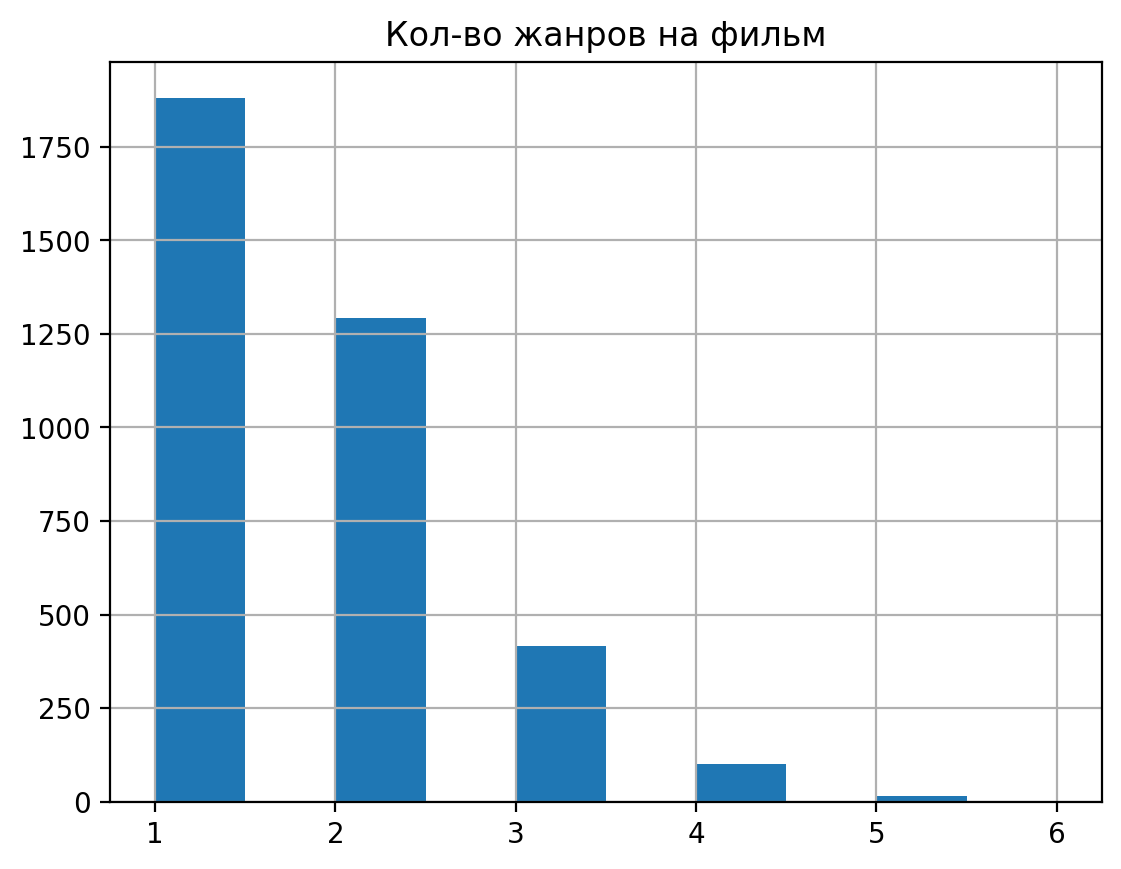

In [21]:
plt.title('Кол-во жанров на фильм')
df_item_feat.gen_cnt.hist()

#### Смторим на популярность жанров

In [24]:
genre_popularity = df_item_feat[genre_columns].sum().reset_index()
genre_popularity.columns = ['genre', 'film_count']
average_genre_count = df_item_feat['gen_cnt'].mean()

print(genre_popularity)
print(f'Среднее количество жанров на фильм: {average_genre_count}')

       genre  film_count
0    genre_0         495
1    genre_1         281
2    genre_2         105
3    genre_3         250
4    genre_4        1163
5    genre_5         201
6    genre_6         110
7    genre_7        1493
8    genre_8          68
9    genre_9          44
10  genre_10         339
11  genre_11         113
12  genre_12         104
13  genre_13         459
14  genre_14         274
15  genre_15         485
16  genre_16         141
17  genre_17          67
Среднее количество жанров на фильм: 1.6708041014570967


#### Данные по событиям (оценка пользователей во времени)

In [28]:
# всего дат
len(set(df_events.timestamp))

2256

<Axes: title={'center': 'Распределение оценкок'}>

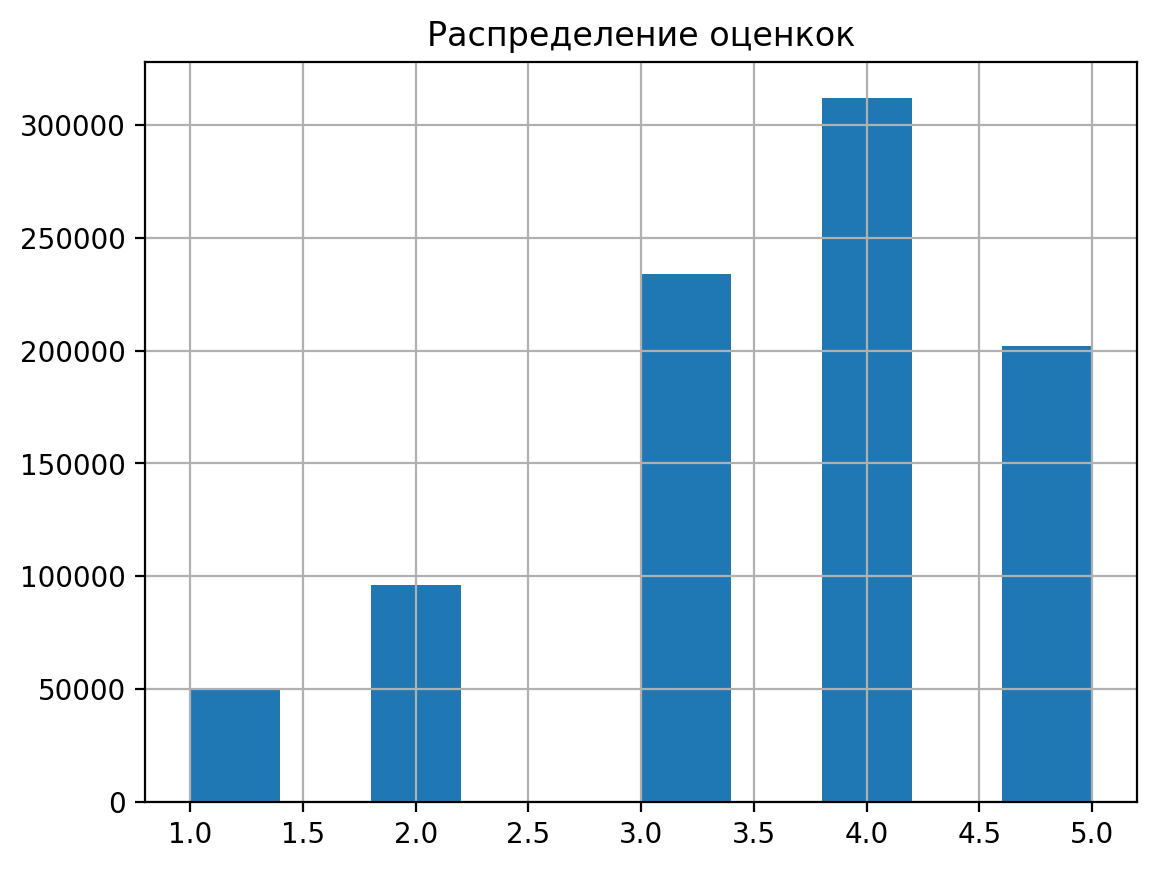

In [30]:
plt.title('Распределение оценкок')
df_events.rating.hist()

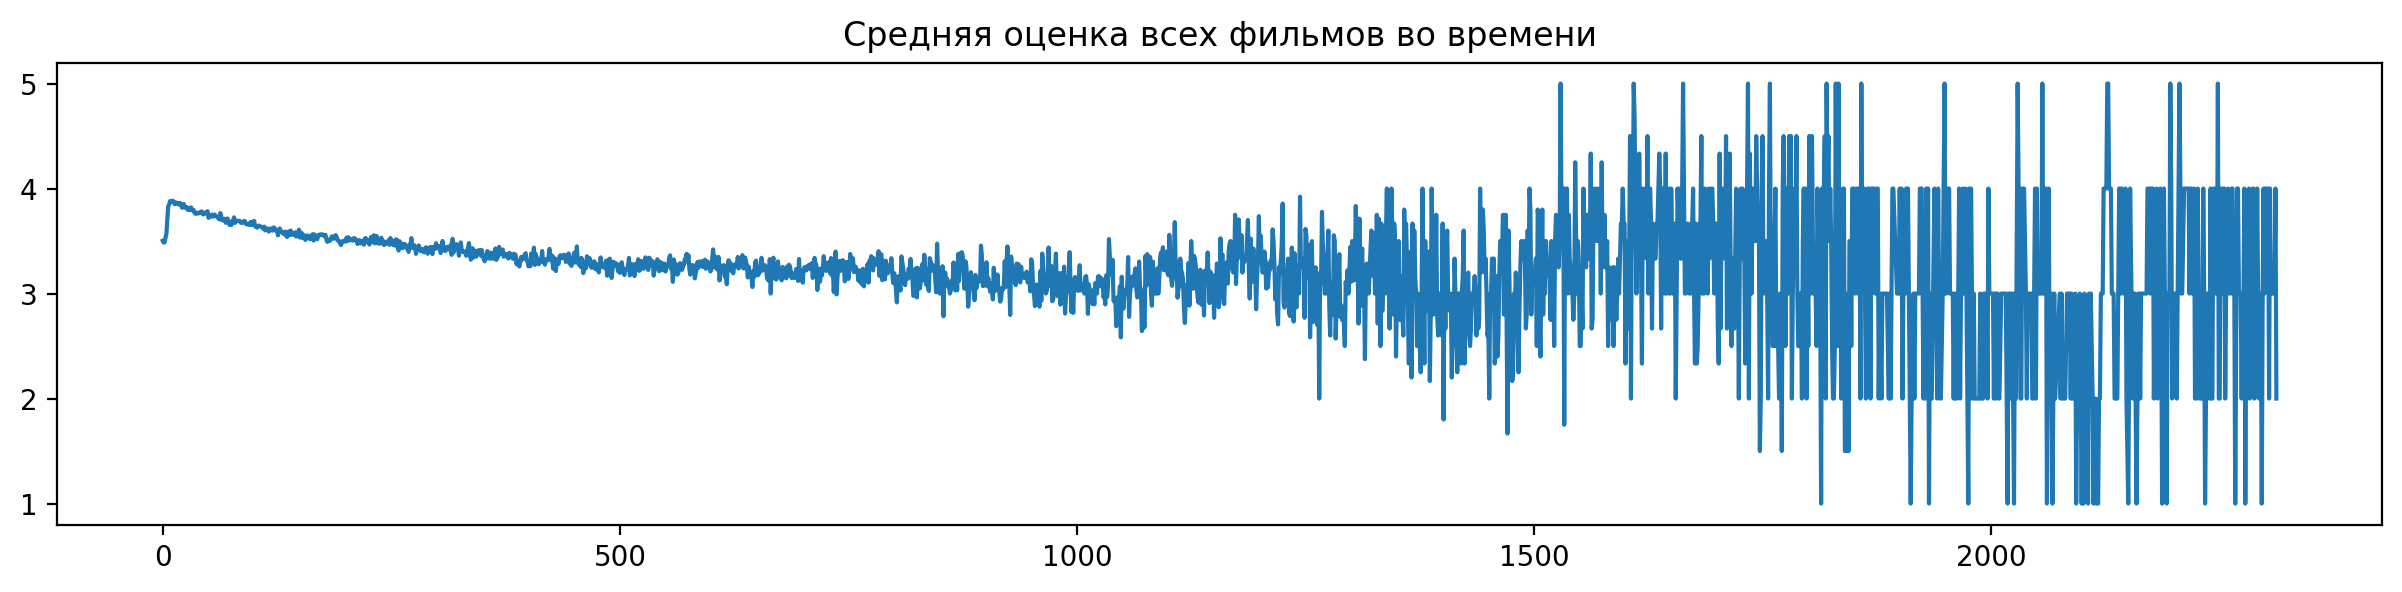

In [32]:
grouped_rating = df_events.groupby(by = ['timestamp','user_id']).mean().reset_index()
grouped_rating = grouped_rating.groupby(by = ['timestamp']).mean().reset_index()

plt.figure(figsize = (15,3))
plt.title('Средняя оценка всех фильмов во времени')
plt.plot(grouped_rating.timestamp,grouped_rating.rating)

**Как изменялась оценка по топу самых популярных фильмов**

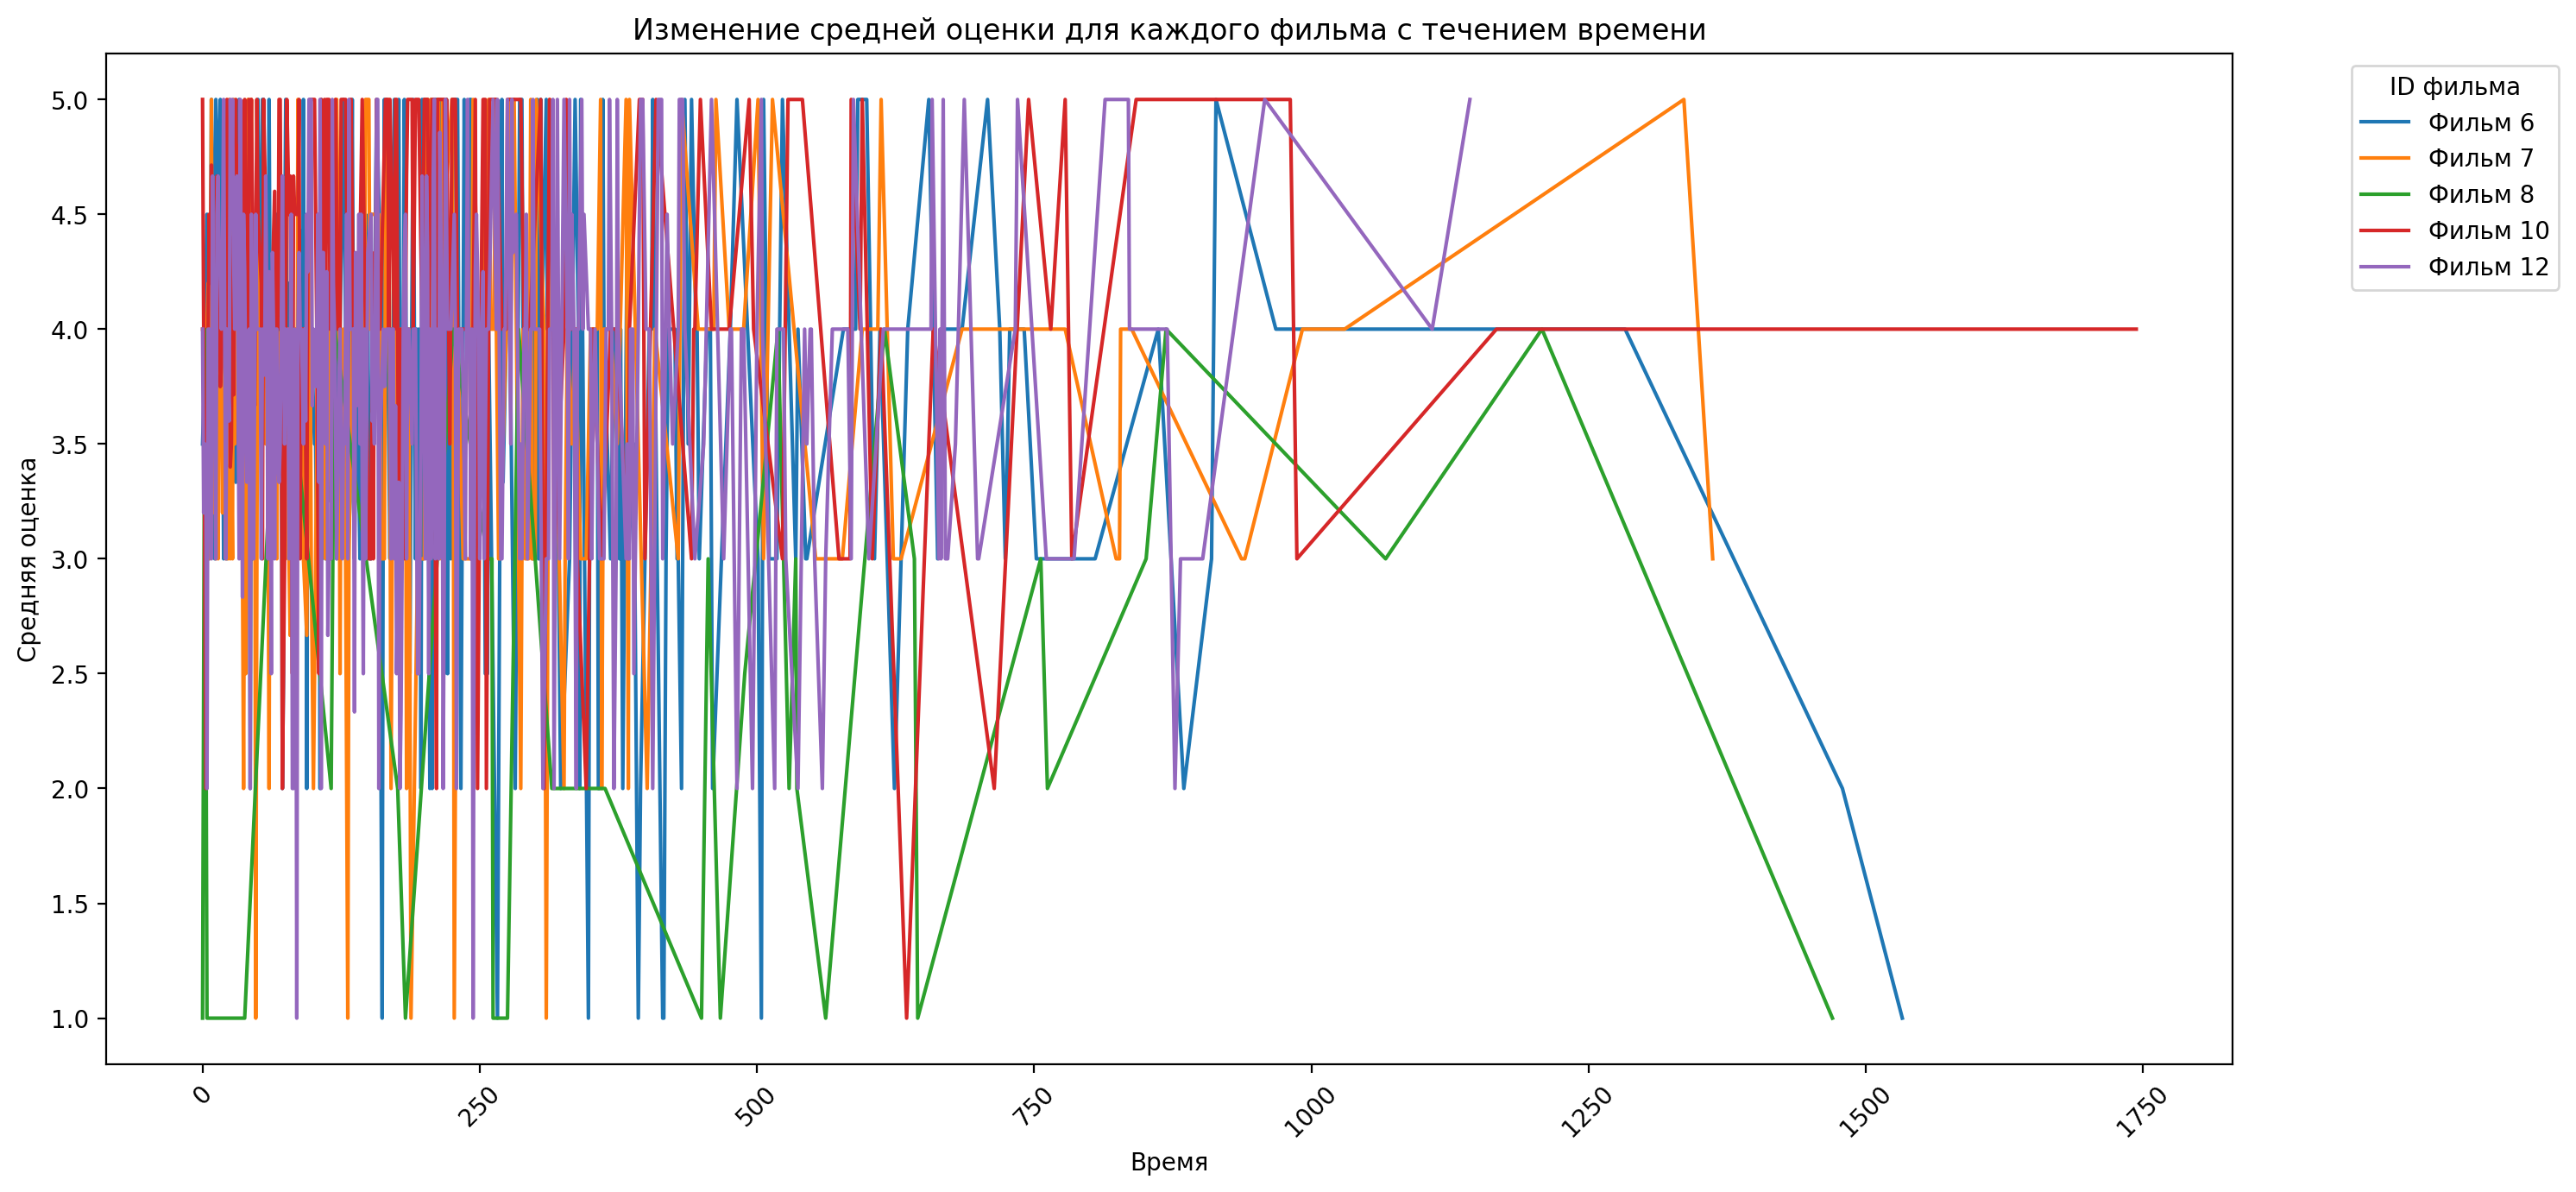

In [35]:
grouped_rating = df_events.groupby(by = ['timestamp','item_id']).mean().reset_index()

# все фильмы
unique_items = grouped_rating['item_id'].unique()[:5]

plt.figure(figsize=(15, 7))
plt.title('Изменение средней оценки для каждого фильма с течением времени')

for item in unique_items:
    movie_data = grouped_rating[grouped_rating['item_id'] == item]
    plt.plot(movie_data['timestamp'], movie_data['rating'], label=f'Фильм {item}')

plt.xticks(rotation=45)  
plt.xlabel('Время')
plt.ylabel('Средняя оценка')
plt.legend(title='ID фильма', bbox_to_anchor=(1.05, 1), loc='upper left')  # Легенда с фильмами
plt.tight_layout()
plt.show()

In [39]:
# минимальная и максимальная дата оценки для каждого фильма
movie_lifetime = df_events.groupby('item_id').agg(
    first_rating=('timestamp', 'min'),
    last_rating=('timestamp', 'max')
).reset_index()

# время существования фильма (разница между последней и первой оценкой)
movie_lifetime['lifetime'] = (movie_lifetime['last_rating'] - movie_lifetime['first_rating'])

# среднее время существования всех фильмов
average_lifetime = movie_lifetime['lifetime'].mean()

print(f"Среднее время существования фильма: {average_lifetime} дней")


df_item_feat = df_item_feat.merge(movie_lifetime[['item_id', 'lifetime']], on='item_id', how='left')
df_item_feat.head()


Среднее время существования фильма: 1290.0392953929538 дней


,item_id,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,...,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,gen_cnt,lifetime
0,0,0,1,0,1,1,0,0,0,1,...,0,0,0,1,0,0,0,0,5,1257.0
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1210.0
2,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1412.0
3,3,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,2,1208.0
4,4,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1665.0


In [41]:
df_events = df_events.sort_values(by=['item_id', 'timestamp'])

df_events['first_rating_time'] = df_events.groupby('item_id')['timestamp'].transform('min')
df_events['time_since_first_rating'] = df_events['timestamp'] - df_events['first_rating_time']
df_events['cumulative_rating_sum'] = df_events.groupby('item_id')['rating'].cumsum() - df_events['rating']

df_events['rating_count'] = df_events.groupby('item_id').cumcount()

df_events['average_rating_before'] = df_events['cumulative_rating_sum'] / df_events['rating_count']
df_events['average_rating_before'] = df_events['average_rating_before'].fillna(0)  # Если это первая оценка

df_events['average_lifetime_before'] = df_events.groupby('item_id')['time_since_first_rating'].transform(lambda x: x.expanding().mean())

df_events.head()


,user_id,item_id,rating,timestamp,first_rating_time,time_since_first_rating,cumulative_rating_sum,rating_count,average_rating_before,average_lifetime_before
312868,2107,0,3,1,1,0,0,0,0.000000,0.000000
592338,3977,0,2,3,1,2,3,1,3.000000,1.000000
604709,4060,0,3,3,1,2,5,2,2.500000,1.333333
616182,4135,0,3,3,1,2,8,3,2.666667,1.500000
511725,3435,0,3,4,1,3,11,4,2.750000,1.800000


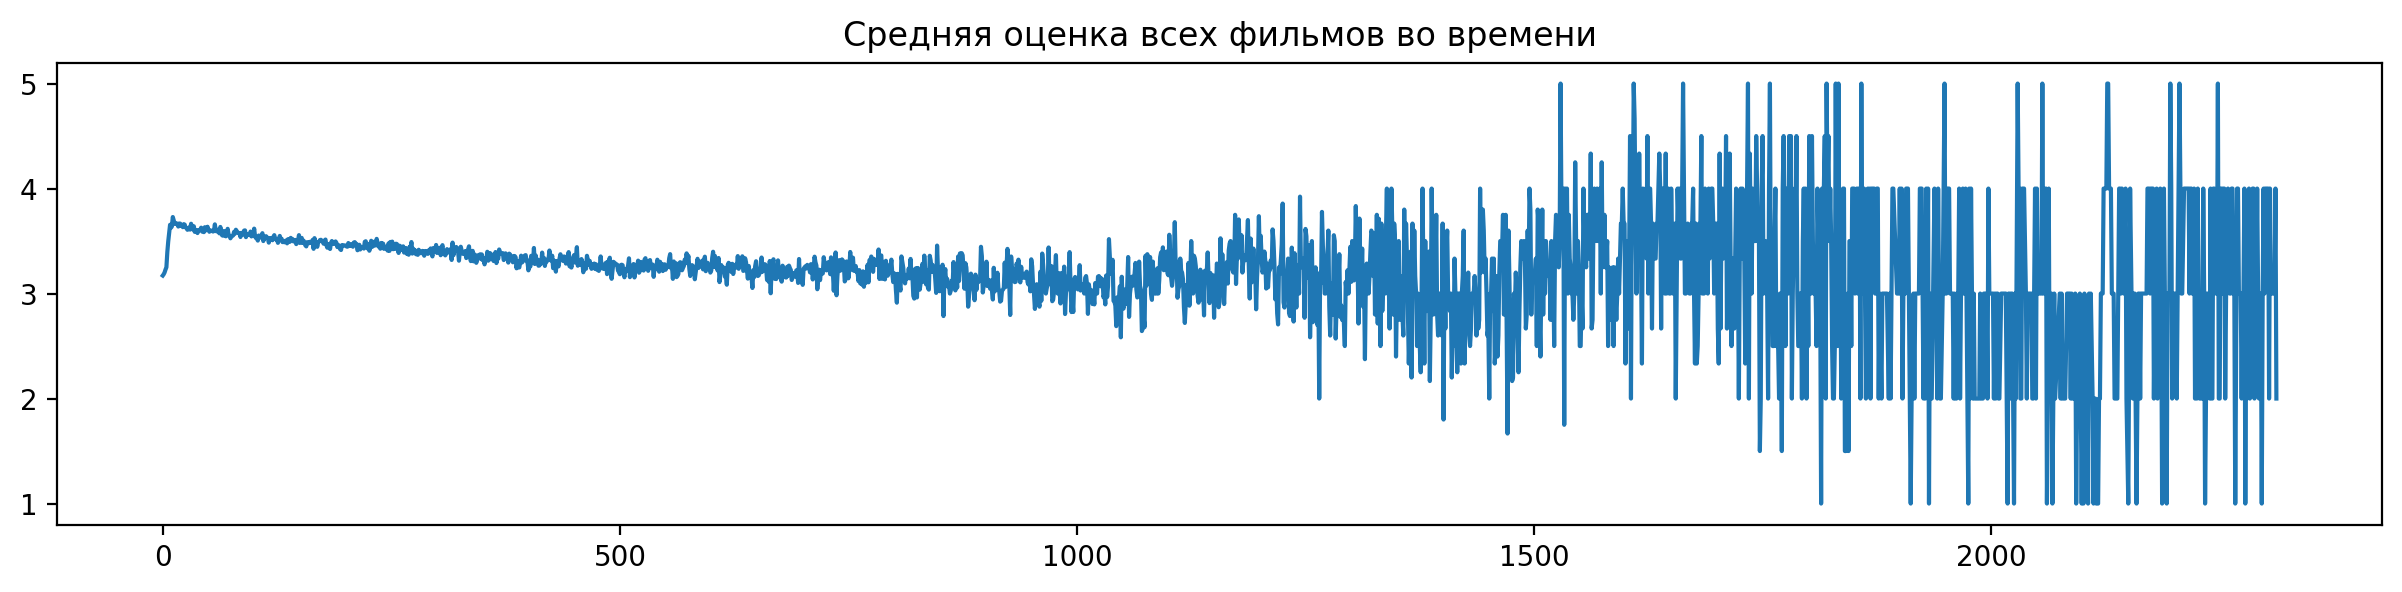

In [44]:
grouped_rating = df_events.groupby(by = ['timestamp','item_id']).mean().reset_index()
grouped_rating = grouped_rating.groupby(by = ['timestamp']).mean().reset_index()

plt.figure(figsize = (15,3))
plt.title('Средняя оценка всех фильмов во времени')
plt.plot(grouped_rating.timestamp,grouped_rating.rating)

<Axes: >

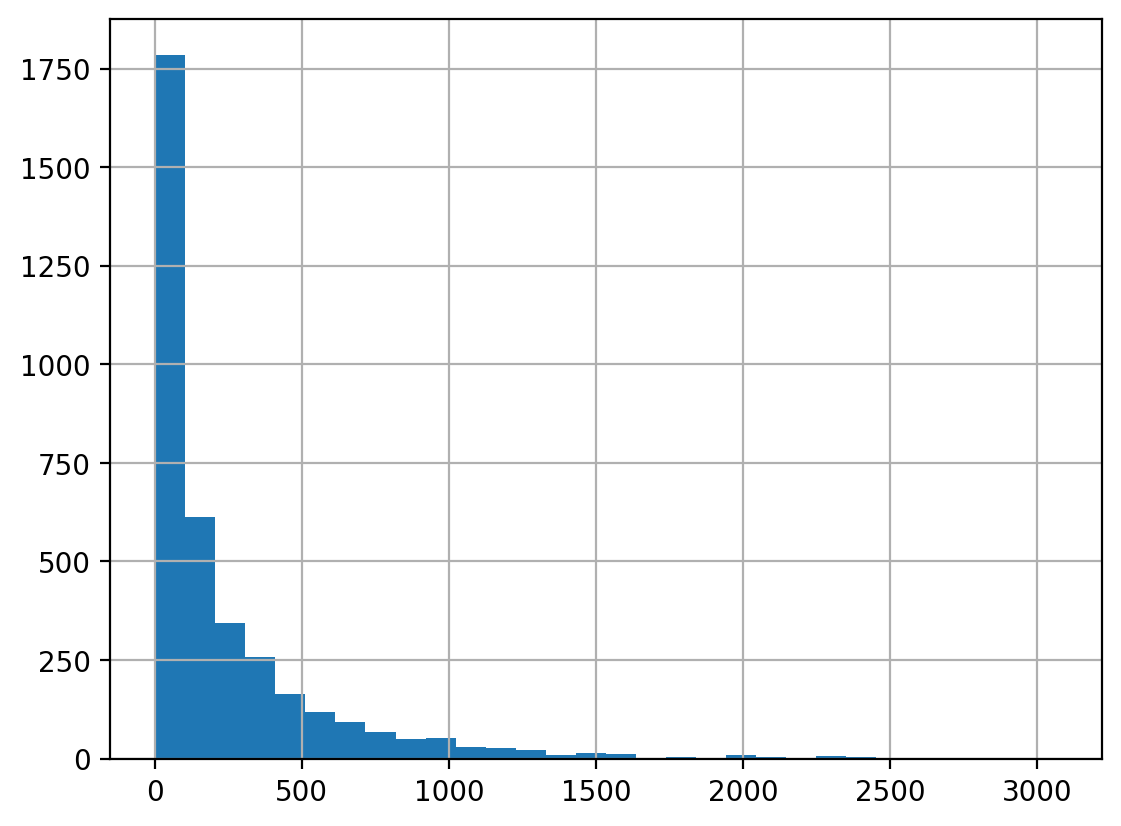

In [45]:
df_events.groupby(by = 'item_id').count().reset_index().user_id.hist(bins = 30)

<Axes: >

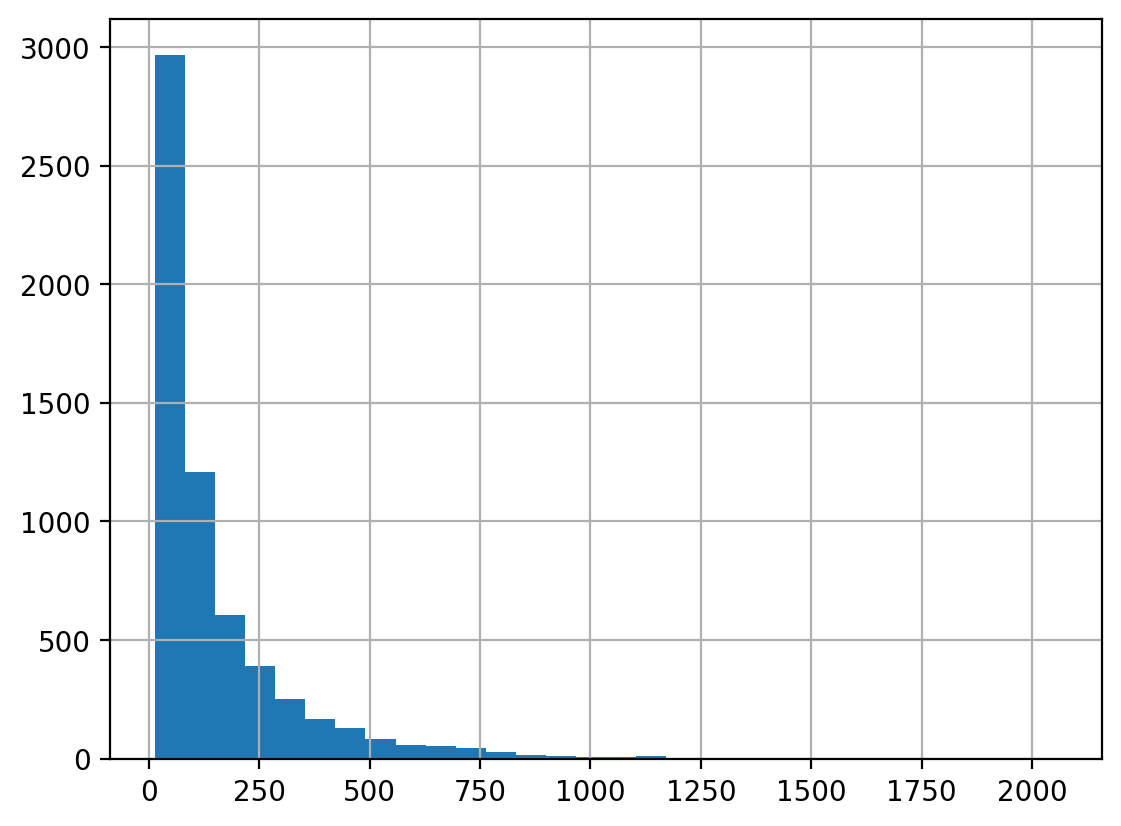

In [48]:
df_events.groupby(by = 'user_id').count().reset_index().item_id.hist(bins = 30)

In [53]:
df_user_feat.head()

,user_id,gender,age
0,4855,F,1
1,4065,M,56
2,3331,M,25
3,5373,M,45
4,2032,M,25


In [62]:
df_sub_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  6040 non-null   int64 
 1   item_id  6040 non-null   object
dtypes: int64(1), object(1)
memory usage: 94.5+ KB


In [57]:
df_sub_sample.groupby(by = 'item_id').count()

,user_id
item_id,
0 1 2 3 4 5 6 7 8 9,6040


#### Семплирование переменных

In [ ]:
# Это из ноута Яны

In [61]:
import pandas as pd

def split_data_by_user(df, test_size=1, val_size=1):
    """
    Функция разделения данных на обучающую, валидационную и тестовую выборки.
    
    :param df: DataFrame с данными
    :param test_size: размер тестового набора (по умолчанию 1)
    :param val_size: размер валидационного набора (по умолчанию 1)
    :return: три DataFrame: train_df, val_df, test_df
    """
    # Группируем данные по каждому пользователю
    grouped = df.groupby('user_id')
    
    # Список для хранения индексов каждой группы
    train_indices = []
    val_indices = []
    test_indices = []
    
    # Проходимся по каждой группе
    for _, group in grouped:
        # Сортируем группу по timestamp
        sorted_group = group.sort_values(by='timestamp', ascending=False)
        
        # Получаем индексы для каждой выборки
        test_idx = sorted_group.index[:test_size]
        val_idx = sorted_group.index[test_size:test_size + val_size]
        train_idx = sorted_group.index[test_size + val_size:]
        
        # Добавляем индексы в соответствующие списки
        train_indices.extend(train_idx)
        val_indices.extend(val_idx)
        test_indices.extend(test_idx)
    
    # Формируем DataFrames для каждой выборки
    train_df = df.loc[train_indices].copy()
    val_df = df.loc[val_indices].copy()
    test_df = df.loc[test_indices].copy()
    
    return train_df, val_df, test_df

In [63]:
# Пример использования функции
train_df, val_df, test_df = split_data_by_user(df_events)

print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)
print("Test shape:", test_df.shape)

Train shape: (882069, 10)
Val shape: (6040, 10)
Test shape: (6040, 10)


In [65]:
def create_non_seen_films_dataset(featured_train_df, user_features_df, item_features_df):
    # Создаем копию featured_train_df, чтобы не изменять оригинальный DataFrame
    df = featured_train_df.copy()
    
    # Получаем список всех уникальных пользователей и фильмов
    unique_users = df["user_id"].unique()
    unique_items = df["item_id"].unique()
    
    # Создаем полный DataFrame с всеми возможными комбинациями пользователей и фильмов
    index = pd.MultiIndex.from_product([unique_users, item_features_df["item_id"]], names=["user_id", "item_id"])
    non_seen_films_df = pd.DataFrame(index=index).reset_index()
    
    # Добавляем признаки пользователей
    non_seen_films_df = non_seen_films_df.merge(user_features_df, on="user_id", how="left")
    
    # Добавляем признаки фильмов
    non_seen_films_df = non_seen_films_df.merge(item_features_df, on="item_id", how="left")
    
    # Оставляем только те пары, которых нет в тренировочном наборе
    non_seen_films_df = non_seen_films_df[~non_seen_films_df.set_index(["user_id", "item_id"]).index.isin(df.set_index(["user_id", "item_id"]).index)]
    
    return non_seen_films_df

In [67]:
non_seen_films_df = create_non_seen_films_dataset(train_df, df_user_feat, df_item_feat)
non_seen_films_df.head()

,user_id,item_id,gender,age,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,...,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,gen_cnt,lifetime
0,0,0,M,35,0,1,0,1,1,0,...,0,0,0,1,0,0,0,0,5,1257.0
1,0,1,M,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1210.0
2,0,2,M,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1412.0
3,0,3,M,35,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,2,1208.0
4,0,4,M,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1665.0


In [69]:
len(non_seen_films_df)
filtered_df = df_events.merge(non_seen_films_df, on=['user_id', 'item_id'], how='inner')
filtered_df.head()

,user_id,item_id,rating,timestamp,first_rating_time,time_since_first_rating,cumulative_rating_sum,rating_count,average_rating_before,average_lifetime_before,...,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,gen_cnt,lifetime
0,3731,0,2,291,1,290,252,100,2.520000,120.960396,...,0,0,0,1,0,0,0,0,5,1257.0
1,5841,1,3,230,15,215,28,8,3.500000,85.333333,...,0,0,0,0,0,0,0,0,1,1210.0
2,751,2,5,27,1,26,49,14,3.500000,11.600000,...,0,0,0,0,0,0,0,0,1,1412.0
3,2697,2,4,34,1,33,72,20,3.600000,17.142857,...,0,0,0,0,0,0,0,0,1,1412.0
4,4479,2,4,170,1,169,401,112,3.580357,76.911504,...,0,0,0,0,0,0,0,0,1,1412.0


**Составление матриц: пользователь*объект**

In [72]:
n_users = df_user_feat['user_id'].nunique()
n_items = df_item_feat['item_id'].nunique()

n_users, n_items

(6040, 3706)

In [76]:
user_item_matrix = np.zeros((n_users, n_items))
for line in filtered_df.itertuples():
    user_item_matrix[line[1], line[2]] = line[3]
user_item_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Варианты моделей

- top -
- LastN - последняя оценка от пользователя
- KNN
- ALS

*Здесь пытаемся предсказать скоры для каждого непосмотренного фильма*

#### Top-popular

In [84]:
def predict_top(user_item_matrix):
    """
    Генерация предсказаний для Top модели 
    """
    num_users, num_items = user_item_matrix.shape
    predictions = []

# смотрим на популярность фильма
    popularity = np.sum(user_item_matrix > 0, axis=0)

# нормализация
    min_popularity = np.min(popularity)
    max_popularity = np.max(popularity)
    normalized_popularity = 5 * (popularity - min_popularity) / (max_popularity - min_popularity)

    for user_id in tqdm(range(num_users),desc = 'top_user_score_loading...'):
        for item_id in range(num_items):  
# в качестве оценки оценка другими пользователями
            predicted_score = normalized_popularity[item_id] 
            predictions.append({'user': user_id, 'item': item_id, 'topn_score': predicted_score})
    return pd.DataFrame(predictions)


In [86]:
topn_scores = predict_top(user_item_matrix)
topn_scores.head()

top_user_score_loading...: 100%|██████████| 6040/6040 [00:02<00:00, 2625.40it/s]


,user,item,topn_score
0,0,0,0.076923
1,0,1,0.076923
2,0,2,0.230769
3,0,3,0.461538
4,0,4,0.000000


#### LastN - по последним предсказаниям пользователя

In [89]:
def predict_lastn(user_item_matrix):
    """
    Генерация предсказаний для LastN модели в формате user | item | score.

    """
    num_users, num_items = user_item_matrix.shape
    predictions = []

    # Предсказания для каждого пользователя на основе последнего взаимодействия
    for user_id in tqdm(range(num_users), desc = 'last_score_prediction...'):
        last_items = np.where(user_item_matrix[user_id] > 0)[0]
        if len(last_items) > 0:
    # последний фильм
            last_item_id = last_items[-1]  
    # Оценка последнего фильма
            last_score = user_item_matrix[user_id, last_item_id]  
            for item_id in range(num_items):
                predicted_score = last_score  
                predictions.append({'user': user_id, 'item': item_id, 'lastn_score': predicted_score})

    return pd.DataFrame(predictions)



In [91]:
last_scores = predict_lastn(user_item_matrix)
last_scores.head()

last_score_prediction...: 100%|██████████| 6040/6040 [00:01<00:00, 3627.01it/s]


,user,item,lastn_score
0,0,0,2.0
1,0,1,2.0
2,0,2,2.0
3,0,3,2.0
4,0,4,2.0


#### KNN-model

In [94]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.neighbors import NearestNeighbors

from tqdm import tqdm
from sklearn.metrics import mean_squared_error

In [96]:
def simple_knn_train(user_item_matrix, n_neighbors=10, metric='cosine'):
    knn_model = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, algorithm='brute')
    knn_model.fit(user_item_matrix)
    
    return knn_model

def predict_for_user(knn_model, user_id, user_item_matrix):
    user_data = user_item_matrix[user_id].reshape(1, -1)
    distances, indices = knn_model.kneighbors(user_data, return_distance=True)
    
    return indices, distances

In [103]:
# def predict_all_scores(knn_model, user_item_matrix, n_neighbors=10):
#     """
#     Скор для всех пар пользователь-объект на основе KNN модели.
#     """
#     num_users, num_items = user_item_matrix.shape
#     all_scores = np.zeros((num_users, num_items))  
    
#     for user_id in tqdm(range(num_users),desc = 'user_knn_loading...'):
#         user_data = user_item_matrix[user_id].reshape(1, -1)
#         distances, indices = knn_model.kneighbors(user_data, n_neighbors=n_neighbors, return_distance=True)
        
#         for item_id in range(num_items):
#         # если не было оценки фильма от юзера
#             if user_item_matrix[user_id, item_id] == 0: 
#                 neighbor_scores = []
#                 for neighbor in indices.flatten():
#                     if user_item_matrix[neighbor, item_id] > 0:  
#                         neighbor_scores.append(user_item_matrix[neighbor, item_id])
                
#                 if neighbor_scores:
#                     all_scores[user_id, item_id] = np.mean(neighbor_scores)
    
#     return all_scores

In [105]:
# knn_model = simple_knn_train(user_item_matrix, n_neighbors=5)
# all_scores = predict_all_scores(knn_model, user_item_matrix, n_neighbors=5)
# print("Предсказанные оценки для всех пользователей и объектов:\n", all_scores)

In [107]:
def predict_knn(knn_model, user_item_matrix, n_neighbors=10):
    """
    Предсказания для KNN модели в формате user | item | score.
    """
    num_users, num_items = user_item_matrix.shape
    predictions = []

    for user_id in tqdm(range(num_users),desc = 'user_knn_scores...'):
        user_data = user_item_matrix[user_id].reshape(1, -1)
        distances, indices = knn_model.kneighbors(user_data, n_neighbors=n_neighbors, return_distance=True)

        for item_id in range(num_items):
            # нет оценки пользователя
            if user_item_matrix[user_id, item_id] == 0:  
                neighbor_scores = []
                for neighbor in indices.flatten():
                    if user_item_matrix[neighbor, item_id] > 0:
                        neighbor_scores.append(user_item_matrix[neighbor, item_id])

                if neighbor_scores:
                    predicted_score = np.mean(neighbor_scores)
                    predictions.append({'user': user_id, 'item': item_id, 'knn_score': predicted_score})

    return pd.DataFrame(predictions)


In [109]:
knn_model = simple_knn_train(user_item_matrix, n_neighbors=5)
knn_scores = predict_knn(knn_model, user_item_matrix)
knn_scores.head()

user_knn_scores...: 100%|██████████| 6040/6040 [07:28<00:00, 13.47it/s]


,user,item,knn_score
0,0,1049,3.0
1,0,1218,3.0
2,0,1461,2.0
3,0,1507,3.0
4,0,1876,1.0


In [111]:
# knn_scores.to_csv('knn_scores.csv')

In [113]:
knn_scores = pd.read_csv('knn_scores.csv').iloc[:,1:]
knn_scores

,user,item,knn_score
0,0,1049,3.0
1,0,1218,3.0
2,0,1461,2.0
3,0,1507,3.0
4,0,1876,1.0
...,...,...,...
57386,6039,1912,4.0
57387,6039,1916,3.0
57388,6039,2128,5.0
57389,6039,2732,4.0


#### ALS

In [282]:
# !pip install implicit -- это не отработало
# !pip install scikit-surprise

In [115]:
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import train_test_split
import numpy as np

def train_als_with_surprise(user_item_matrix):
    
    num_users, num_items = user_item_matrix.shape
    data = []
    
    for user_id in tqdm(range(num_users), desc = 'als_user_train'):
        for item_id in range(num_items):
            if user_item_matrix[user_id, item_id] > 0:
                data.append((user_id, item_id, user_item_matrix[user_id, item_id]))
    
    
    reader = Reader(rating_scale=(1, 5))
    dataset = Dataset.load_from_df(pd.DataFrame(data, columns=['user', 'item', 'rating']), reader)
    trainset, testset = train_test_split(dataset, test_size=0.2)
    
# модель ALS (SVD в Surprise)
    als_model = SVD(n_factors=50, n_epochs=20, biased=False) 
    als_model.fit(trainset)
    
    return als_model, testset

def predict_als_with_surprise(als_model, testset):
    predictions = als_model.test(testset)
    return predictions


In [117]:
als_model, testset = train_als_with_surprise(user_item_matrix)
als_predictions = predict_als_with_surprise(als_model, testset)

for pred in als_predictions[:5]:
    print(f'User {pred.uid} predicted rating for Item {pred.iid} is {pred.est}')

als_user_train: 100%|██████████| 6040/6040 [00:01<00:00, 3908.12it/s]

User 792 predicted rating for Item 2476 is 3.5994412251655628
User 5148 predicted rating for Item 3276 is 1
User 5480 predicted rating for Item 1459 is 1
User 3295 predicted rating for Item 697 is 3.5994412251655628
User 5487 predicted rating for Item 2006 is 1


In [119]:
als_data = []
for pred in als_predictions:
    als_data.append({
        'user': pred.uid,
        'item': pred.iid,
        'als_score': pred.est
    })

als_scores = pd.DataFrame(als_data)
als_scores

,user,item,als_score
0,792,2476,3.599441
1,5148,3276,1.000000
2,5480,1459,1.000000
3,3295,697,3.599441
4,5487,2006,1.000000
...,...,...,...
2411,1654,1240,1.000000
2412,1970,2953,1.000000
2413,5694,2534,1.000000
2414,1940,2314,1.000000


#### Итоговое сопоставление моделей для комбинаций

In [121]:
combined_df = topn_scores.merge(last_scores, on=['user', 'item'], how='left')
combined_df = combined_df.merge(knn_scores, on=['user', 'item'], how='left')
combined_df = combined_df.merge(als_scores, on=['user', 'item'], how='left')
combined_df = combined_df.fillna(0)
combined_df.head()

,user,item,topn_score,lastn_score,knn_score,als_score
0,0,0,0.076923,2.0,0.0,0.0
1,0,1,0.076923,2.0,0.0,0.0
2,0,2,0.230769,2.0,0.0,0.0
3,0,3,0.461538,2.0,0.0,0.0
4,0,4,0.000000,2.0,0.0,0.0


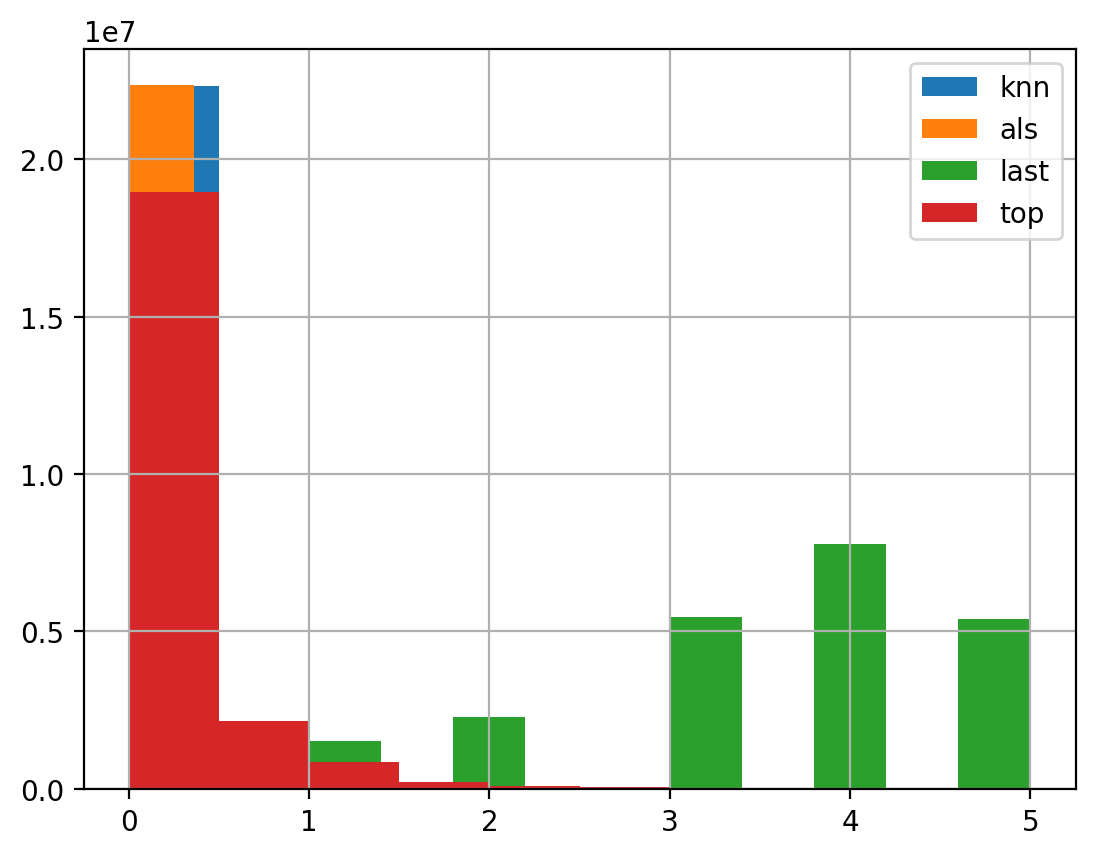

In [144]:
combined_df.knn_score.hist(label = 'knn')
combined_df.als_score.hist(label = 'als')
combined_df.lastn_score.hist(label = 'last')
combined_df.topn_score.hist(label = 'top')
plt.legend()

In [295]:
combined_df

,user,item,topn_score,lastn_score,knn_score,als_score
0,0,0,0.218455,5.0,2.0,0.00000
1,0,1,0.022824,5.0,0.0,0.00000
2,0,2,0.355396,5.0,0.0,0.00000
3,0,3,0.244539,5.0,0.0,0.00000
4,0,4,0.071731,5.0,0.0,0.00000
...,...,...,...,...,...,...
22384235,6039,3701,0.852625,2.0,4.0,0.00000
22384236,6039,3702,0.052168,2.0,0.0,0.00000
22384237,6039,3703,0.001630,2.0,0.0,0.00000
22384238,6039,3704,0.119009,2.0,4.0,0.00000


#### Сомтрим на топ предсказаний для каждого из методов

Для оценки качества каждой модели в зоопарке используем Recall@10:

- Генерация кандидатов для каждой модели (KNN, ALS, LastN) — получаем список топ-k рекомендаций для каждого пользователя
- Сравнение с релевантными объектами — оцениваем, попадают ли рекомендованные объекты в множество релевантных объектов, которые пользователь уже оценил положительно.
- Рассчет Recall@10 — для каждого пользователя считаем, сколько релевантных объектов попало в топ-10 рекомендаций.

In [146]:
def get_top_n_items(pred_df, score_column, top_n=100):

    sorted_df = pred_df.sort_values(by=['user', score_column], ascending=[True, False])
    top_n_df = sorted_df.groupby('user').head(top_n)
    
    return top_n_df


In [148]:
def create_top_df(pred_df, model, n=100):
    
    top_films = {}
    for model in trained_models:
        top_films[model] = get_top_n(
            non_seen_films_with_predictions, model, n=n
        )
    
    result = pd.concat(list(top_films.values()))
    
    return result